## Stochastic Gradient Descent(SGD)

### Load Dataset from sklearn

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing


In [2]:
california = fetch_california_housing()
df = pd.DataFrame(california.data, columns=california.feature_names)
df['target'] = california.target

print(f"description : {california.DESCR}")
df.tail()

description : .. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using 

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


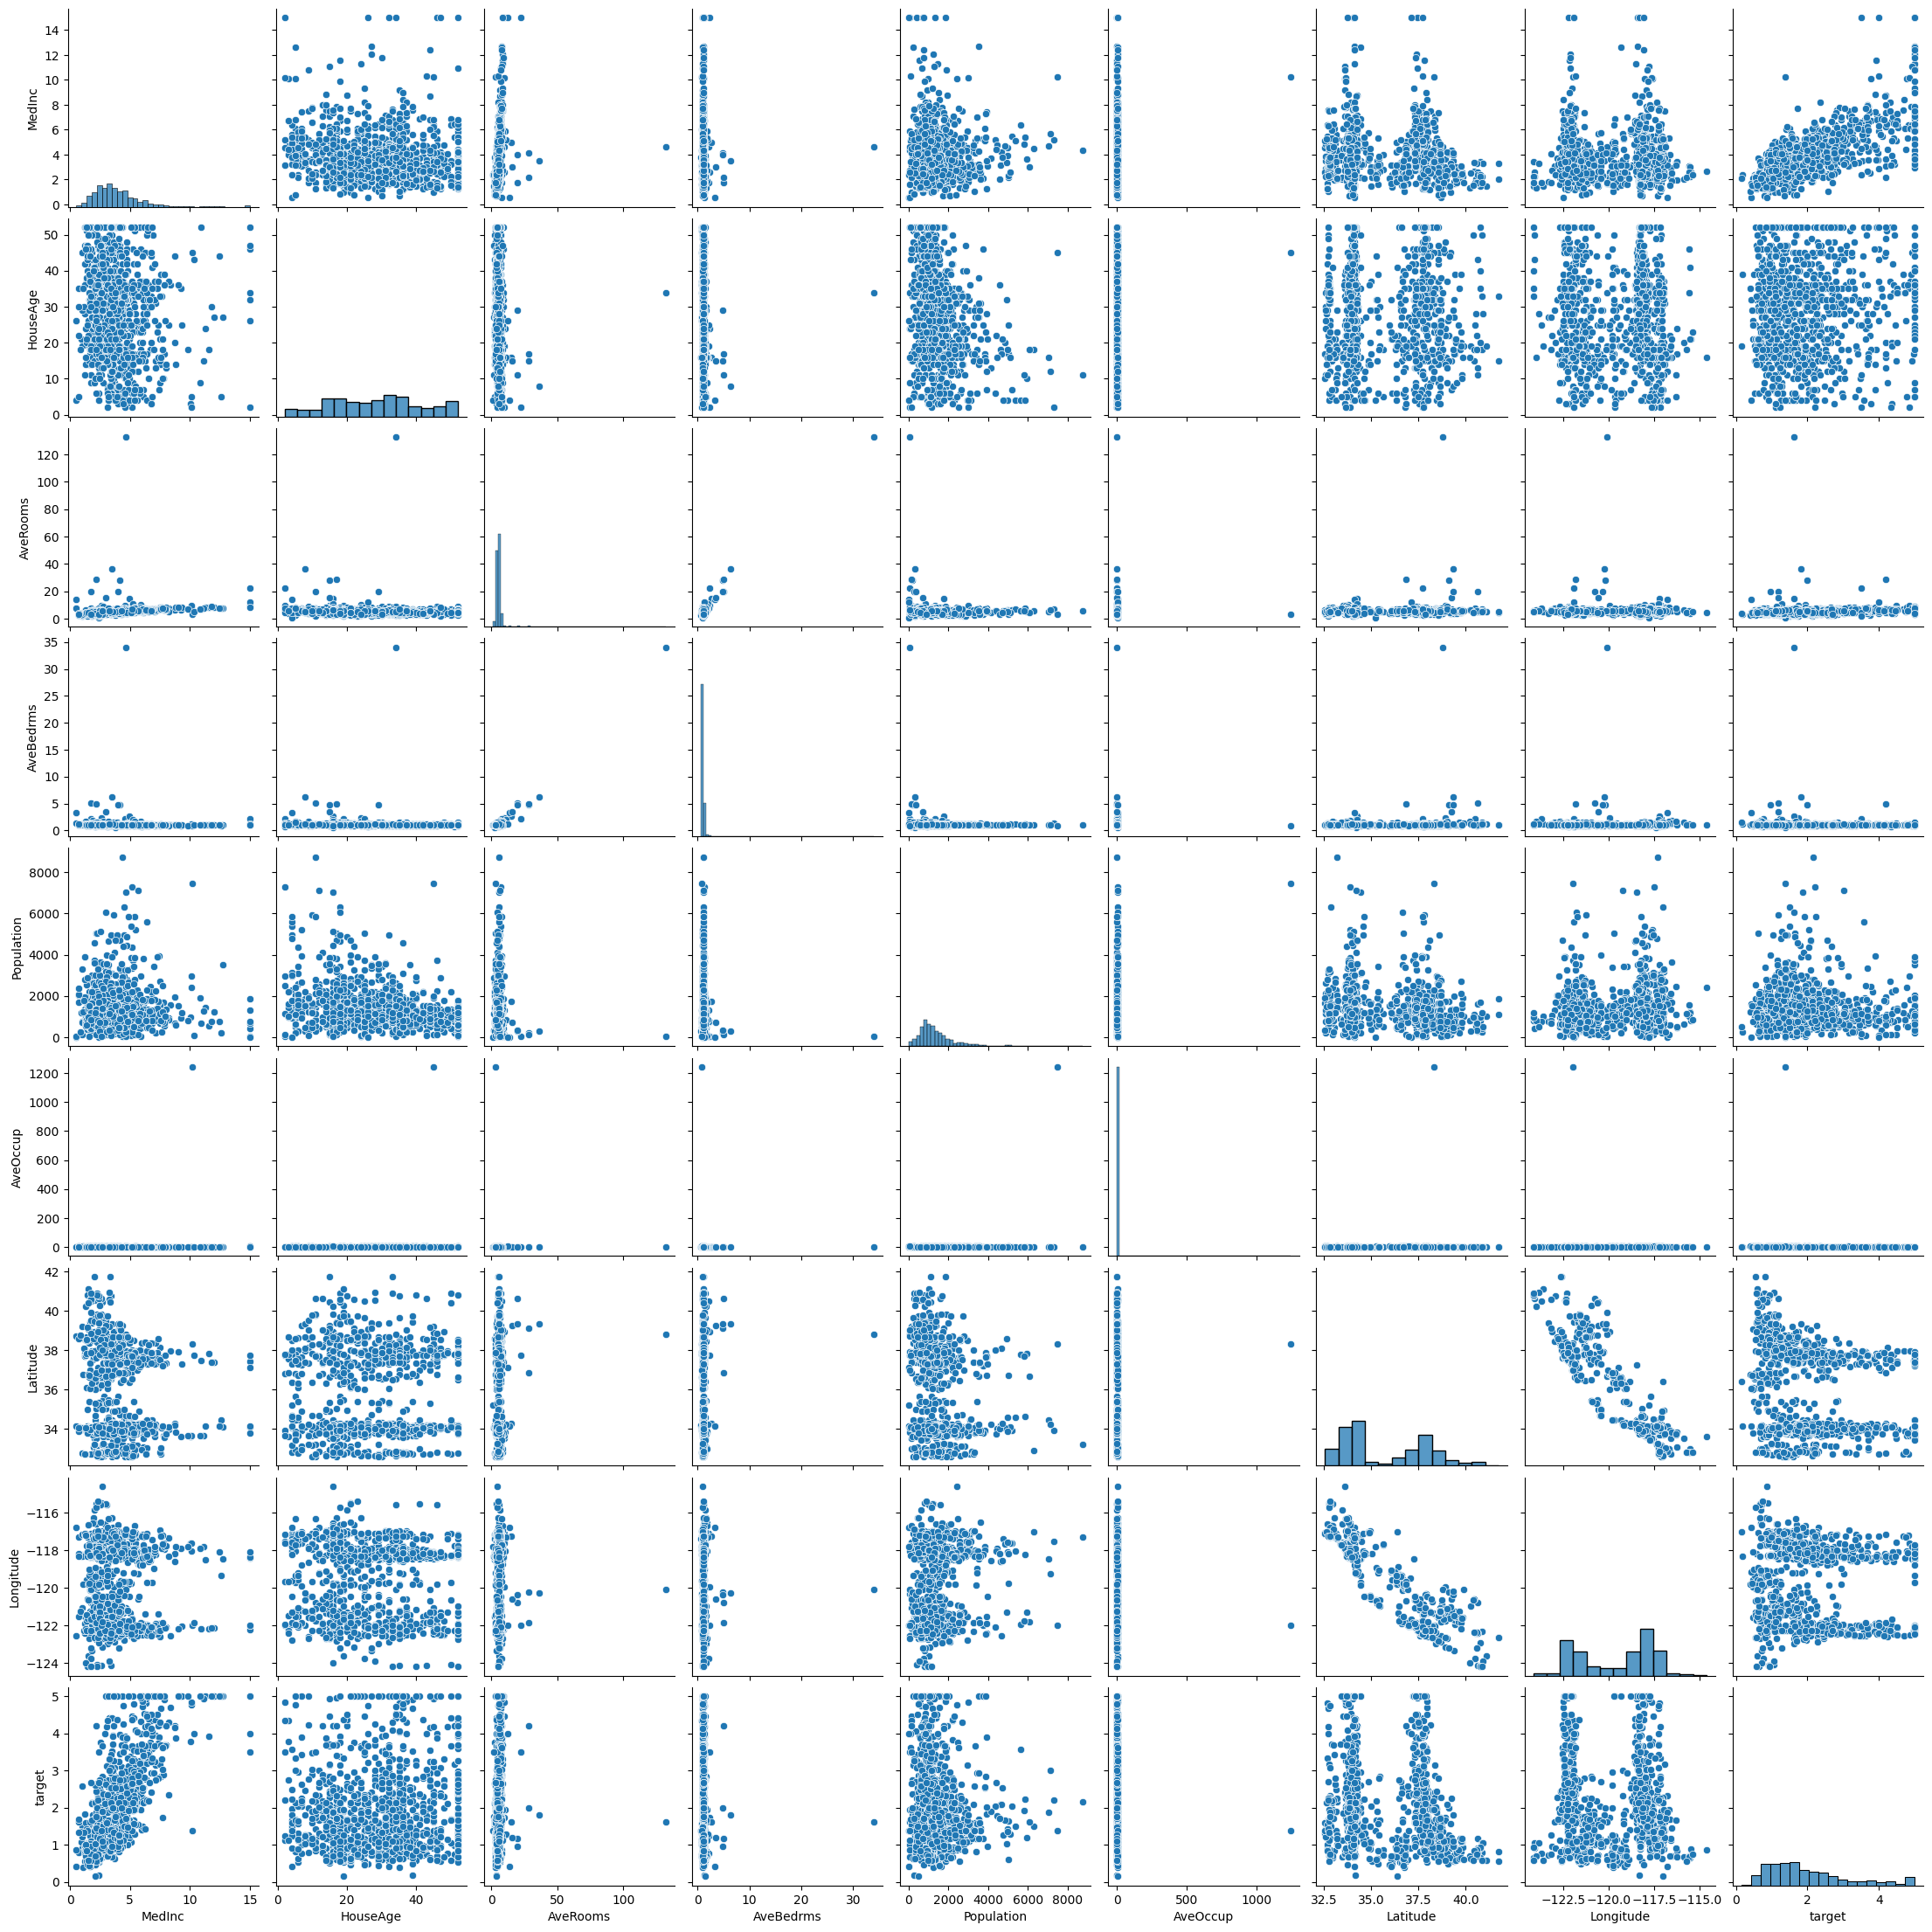

In [3]:
sns.pairplot(df.sample(1000))
plt.show()

In [4]:
scaler = StandardScaler()
df.loc[:, df.columns != 'target'] = scaler.fit_transform(df.loc[: , df.columns != 'target'])
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
20635,-1.216128,-0.289187,-0.155023,0.077354,-0.512592,-0.049110,1.801647,-0.758826,0.781
20636,-0.691593,-0.845393,0.276881,0.462365,-0.944405,0.005021,1.806329,-0.818722,0.771
20637,-1.142593,-0.924851,-0.090318,0.049414,-0.369537,-0.071735,1.778237,-0.823713,0.923
20638,-1.054583,-0.845393,-0.040211,0.158778,-0.604429,-0.091225,1.778237,-0.873626,0.847
20639,-0.780129,-1.004309,-0.070443,0.138403,-0.033977,-0.043682,1.750146,-0.833696,0.894


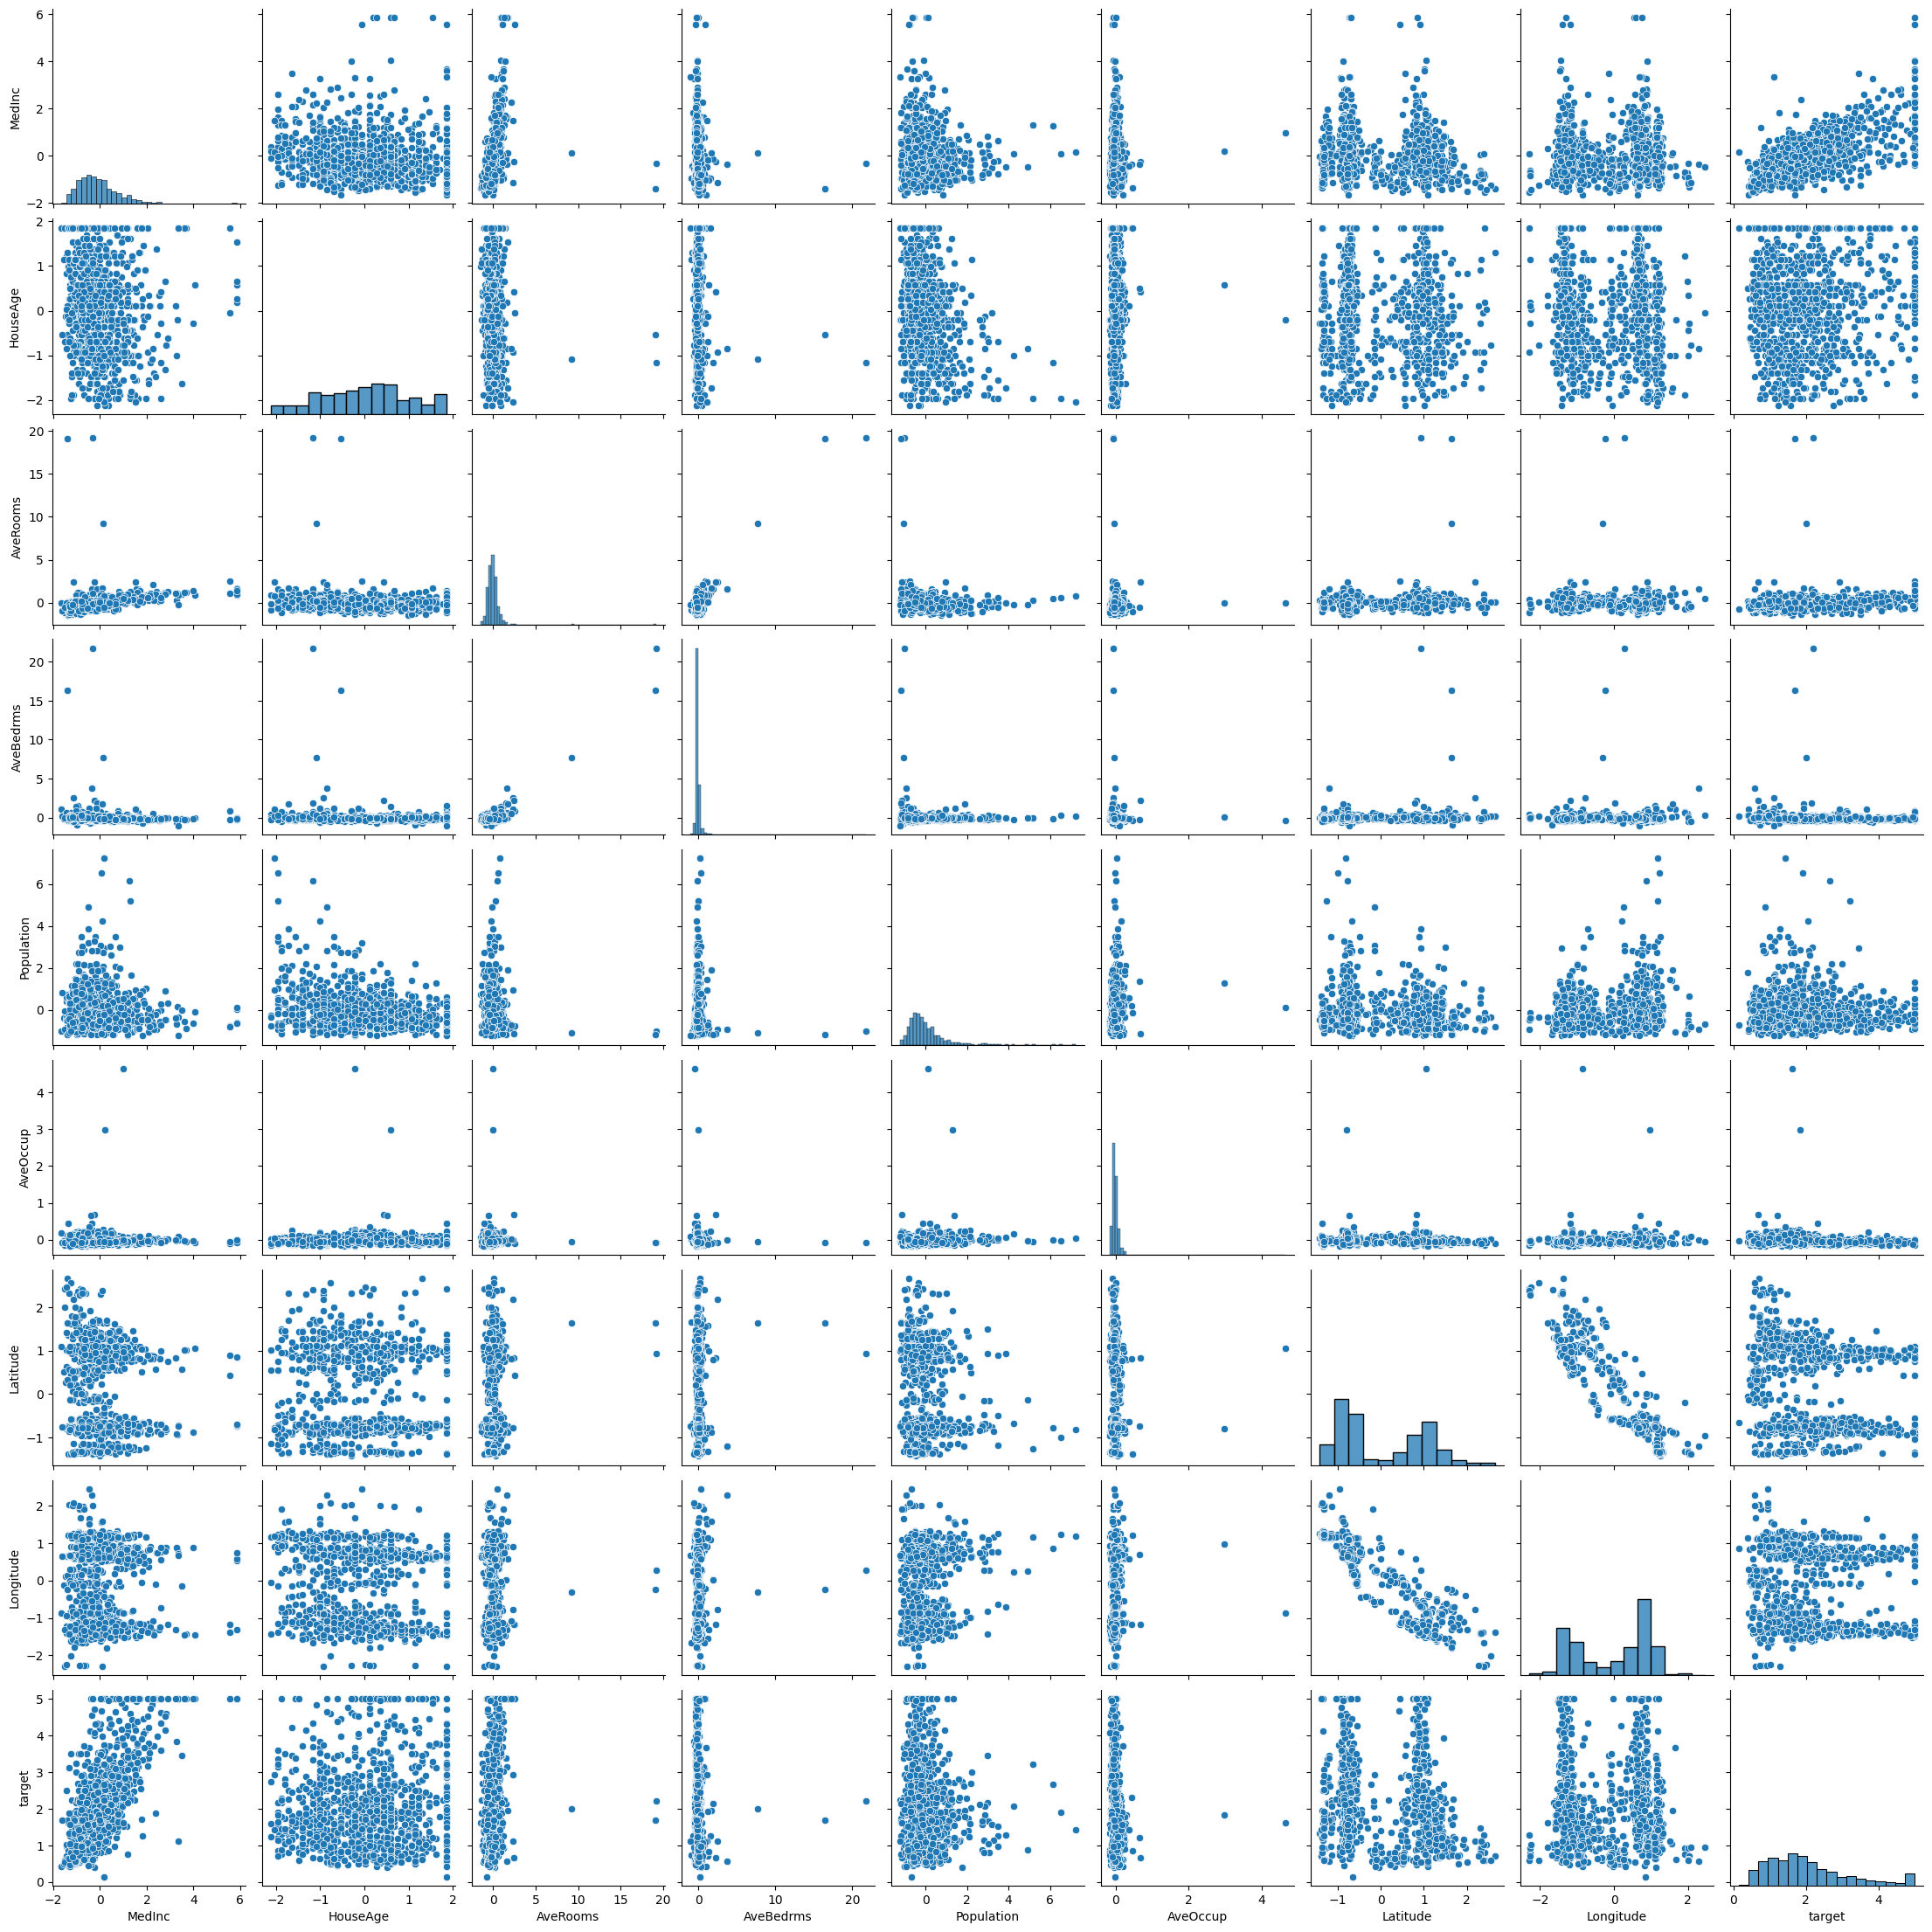

In [5]:
sns.pairplot(df.sample(1000))
plt.show()

### Train Model With PyTorch

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [7]:
data = torch.from_numpy(df.values).float()
print(f"data : {data.shape}, {data.dtype}, {data.device}")

data : torch.Size([20640, 9]), torch.float32, cpu


In [8]:
x = data[:, :-1]
y = data[:, -1:]

print(f"x.shape : {x.shape}, y.shape : {y.shape}")

x.shape : torch.Size([20640, 8]), y.shape : torch.Size([20640, 1])


In [9]:
n_epochs = 4000
batch_size = 256
print_interval = 200
learning_rate = 1e-2

### Build Model

In [10]:
model = nn.Sequential(
    nn.Linear(x.size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1)),
)

model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [11]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
## |X| = (total_size, input_dim)
## |Y| = (total_size, ouput_dim)

for i in range(n_epochs):
    ## Shuffle the index to feed-forward
    indices = torch.randperm(x.size(0))
    x_ = torch.index_select(x, dim=0, index=indices)
    y_ = torch.index_select(y, dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    ## |x_[i]| = (batch_size, input_dim)
    ## |y_[i]| = (batch_size, output_dim)
    
    y_hat = []
    total_loss = 0
    
    for x_i, y_i in zip(x_, y_):
        ## |x_i| = |x_[i]| 
        ## |y_i| = |y_[i]|
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        total_loss += float(loss)
        y_hat += [y_hat_i]
    
    